In [1]:
from autoscalingsim import simulator
import pandas as pd

starting_time = pd.Timestamp("2020-09-17T10:00:00")
simulation_step = pd.Timedelta(10, unit = 'ms')
time_to_simulate_days = 0.0001#0.005
config_dir = "experiments/test"
results_dir = None

simulator = simulator.Simulator(simulation_step,
                                starting_time,
                                time_to_simulate_days)

simulator.add_simulation(config_dir,
                         results_dir)

simulator.start_simulation()

865it [00:32, 26.64it/s]                                                                                               


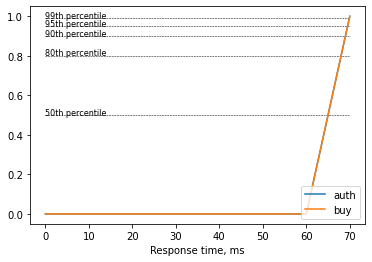

<Figure size 432x288 with 0 Axes>

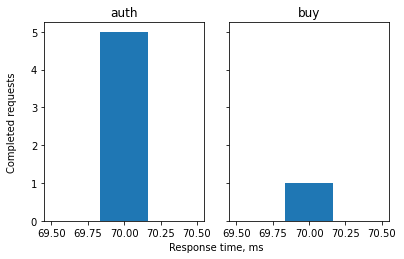

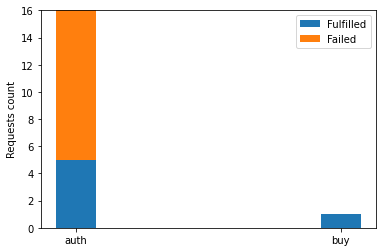

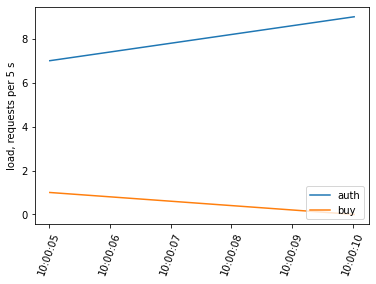

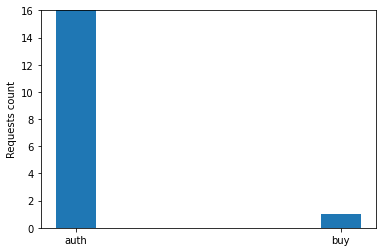

<Figure size 432x288 with 0 Axes>

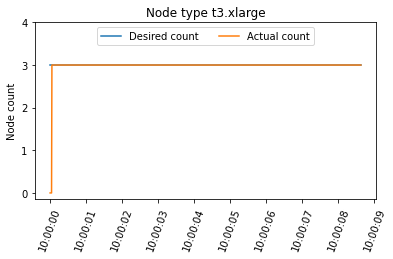

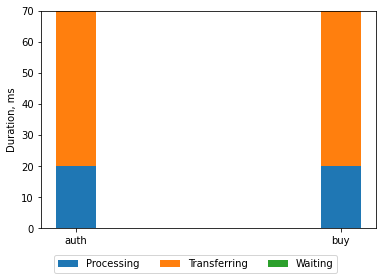

In [2]:
from autoscalingsim.analysis.analytical_engine import AnalysisFramework

af = AnalysisFramework(simulation_step, 'D:/AutoscalingSim/results/test')
af.build_figures(simulator.simulations['test'], '')